<a href="https://colab.research.google.com/github/mrella/finance_colab/blob/main/markov_hidden_lstm_regimen_mercado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install yfinance numpy pandas matplotlib scikit-learn hmmlearn


[*********************100%***********************]  1 of 1 completed


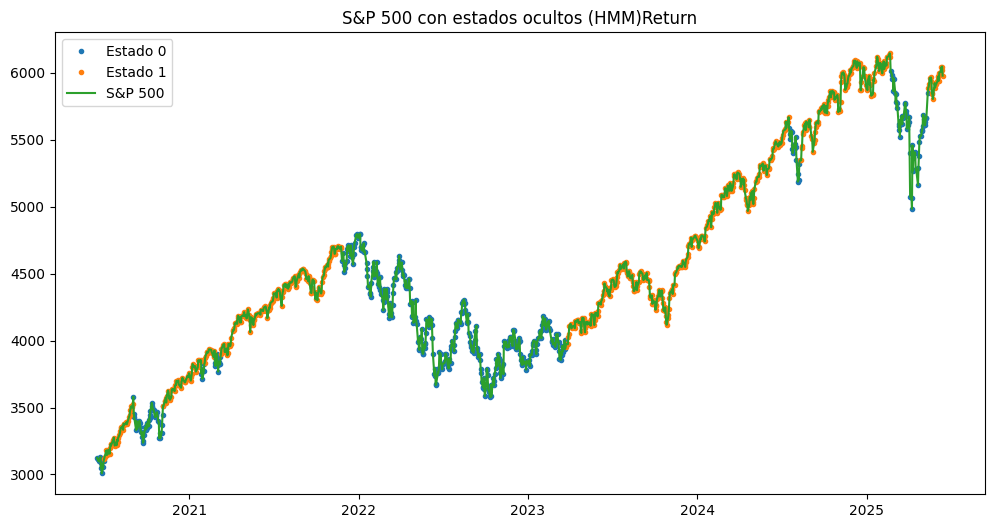

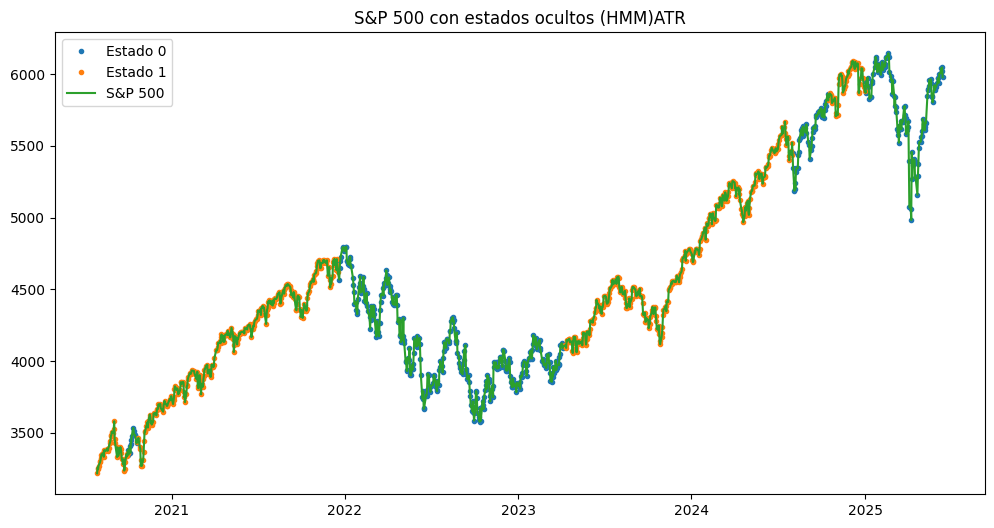

In [11]:
import yfinance as yf
import numpy as np
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Descargar datos históricos del S&P 500 usando yfinance
def descargar_datos(ticker='^GSPC', periodo='5y'):
    data = yf.download(ticker, period=periodo)
    return data

# 2. Calcular volatilidad: True Range y Average True Range (ATR)
def calcular_atr(data, window=30):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=window).mean()
    return atr


def preprocesar_datos_return(data):
    # Calcular retornos logarítmicos
    data['Return'] = np.log(data['Close'] / data['Close'].shift(1))
    # Eliminar filas con NaN (pueden haber valores NaN en las primeras filas por cálculos de ATR)
    data.dropna(inplace=True)
    # Normalizar características: Retornos, Volumen y Volatilidad
    scaler = StandardScaler()
    features = data[['Return']].values
    data.dropna(inplace=True)
    scaled_features = scaler.fit_transform(features)
    return scaled_features, data


def preprocesar_datos_atr(data):
    # Calcular ATR para la volatilidad
    data['Volatility_ATR'] = calcular_atr(data)
    # Eliminar filas con NaN (pueden haber valores NaN en las primeras filas por cálculos de ATR)
    data.dropna(inplace=True)
    scaler = StandardScaler()
    features = data[['Volatility_ATR']].values
    data.dropna(inplace=True)
    scaled_features = scaler.fit_transform(features)
    return scaled_features, data


def preprocesar_datos_atrvol(data):
    data['Return'] = np.log(data['Close'] / data['Close'].shift(1))
    data.dropna(inplace=True)
    data['Volatility_ATR'] = calcular_atr(data)
    data.dropna(inplace=True)
    scaler = StandardScaler()
    features = data[['Return', 'Volatility_ATR']].values
    data.dropna(inplace=True)
    scaled_features = scaler.fit_transform(features)
    return scaled_features, data


def preprocesar_datos_all(data):
    # Calcular retornos logarítmicos
    data['Return'] = np.log(data['Close'] / data['Close'].shift(1))
    # Calcular ATR para la volatilidad
    data['Volatility_ATR'] = calcular_atr(data)
    # Eliminar filas con NaN (pueden haber valores NaN en las primeras filas por cálculos de ATR)
    data.dropna(inplace=True)
    # Normalizar características: Retornos, Volumen y Volatilidad
    scaler = StandardScaler()
    features = data[['Return', 'Volume', 'Volatility_ATR']].values
    #data['Volumen_Monetario'] = data['Volume'] * data['Adj Close']
    data.dropna(inplace=True)
    scaler = StandardScaler()
    #features = scaler.fit_transform(data['Return'].values.reshape(-1, 1))
    scaled_features = scaler.fit_transform(features)
    return scaled_features, data



# 4. Entrenar un modelo HMM
def entrenar_hmm(datos, n_states):
    modelo_hmm = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=3000)
    modelo_hmm.fit(datos)
    estados_ocultos = modelo_hmm.predict(datos)
    return modelo_hmm, estados_ocultos

# 5. Graficar los estados ocultos sobre los datos originales
def graficar_estados(data, estados_ocultos, type):
    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(modelo_hmm.n_components):
        idx = (estados_ocultos == i)
        ax.plot(data.index[idx], data['Close'][idx], '.', label=f"Estado {i}")
    ax.plot(data.index, data['Close'], label='S&P 500')
    plt.title('S&P 500 con estados ocultos (HMM)' + type)
    plt.legend()
    plt.show()

# 6. Ejecutar el análisis completo
if __name__ == "__main__":
    datos = descargar_datos()

    features_scaled, datos_procesados = preprocesar_datos_return(datos)
    modelo_hmm, estados_ocultos = entrenar_hmm(features_scaled, n_states=2)
    graficar_estados(datos_procesados, estados_ocultos, 'Return')

    features_scaled, datos_procesados = preprocesar_datos_atr(datos)
    modelo_hmm, estados_ocultos = entrenar_hmm(features_scaled, n_states=2)
    graficar_estados(datos_procesados, estados_ocultos, 'ATR')


    #features_scaled, datos_procesados = preprocesar_datos_atrvol(datos)
    #modelo_hmm, estados_ocultos = entrenar_hmm(features_scaled, n_states=2)
    #graficar_estados(datos_procesados, estados_ocultos, 'atrreturn')


    #features_scaled, datos_procesados = preprocesar_datos_all(datos)
    #modelo_hmm, estados_ocultos = entrenar_hmm(features_scaled, n_states=2)
    #graficar_estados(datos_procesados, estados_ocultos, 'all')


[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.1060
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0029
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0013
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 8.5698e-04
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 7.9228e-04
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 7.2600e-04
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 7.5965e-04
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 7.4526e-04
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 8.5164e-04
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 7.1894e-04


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


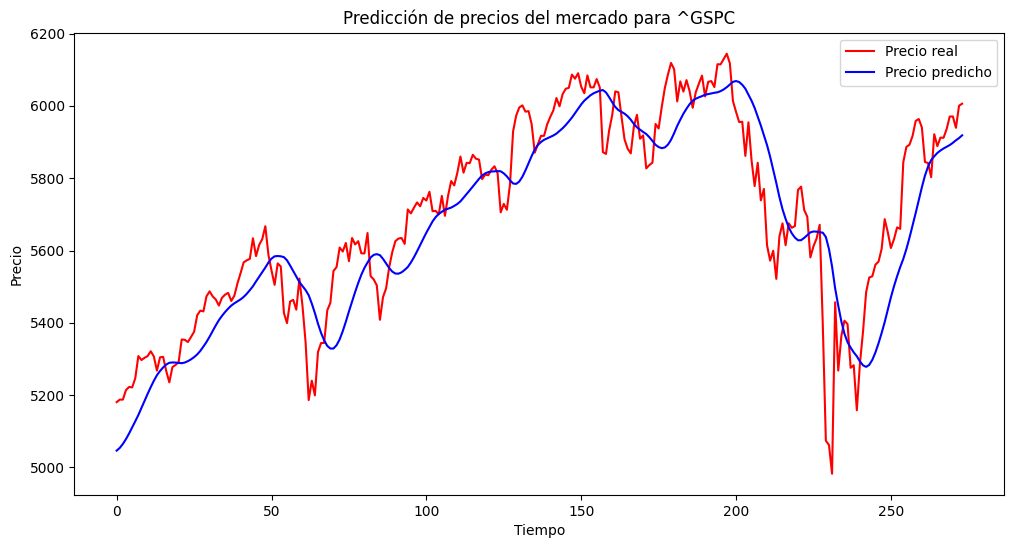

In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Descargar datos de Yahoo Finance
ticker = '^GSPC'  # Puedes cambiar este valor por cualquier otro símbolo (por ejemplo, 'SPY' para el S&P 500)
data = yf.download(ticker, start='2019-10-01', end='2025-06-10')

# Usaremos la columna de precios de cierre ajustado (Adj Close) como la serie temporal de precios
data = data[['Close']]
data = data.rename(columns={'Close': 'Price'})

# 2. Preprocesamiento de datos
prices = data['Price'].values.reshape(-1, 1)

# Normalización de los precios
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# 3. Crear secuencias de entrada y salida
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60  # Usar los últimos 60 días para predecir
X, y = create_sequences(scaled_prices, sequence_length)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Ajustar las dimensiones de entrada (X) para la red LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 4. Definir la red LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))  # Capa de salida

model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32)

# 6. Hacer predicciones
predicted_prices = model.predict(X_test)

# Inversión de la normalización
predicted_prices = scaler.inverse_transform(predicted_prices)

# Comparar con los precios reales
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Visualización
plt.subplots(figsize=(12, 6))
plt.plot(real_prices, color='red', label='Precio real')
plt.plot(predicted_prices, color='blue', label='Precio predicho')
plt.title('Predicción de precios del mercado para ' + ticker)
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.0747
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0016
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0010
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 8.5152e-04
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 7.5589e-04
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 7.4095e-04
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 8.0141e-04
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 6.3601e-04
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 6.7081e-04
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 6.4431e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


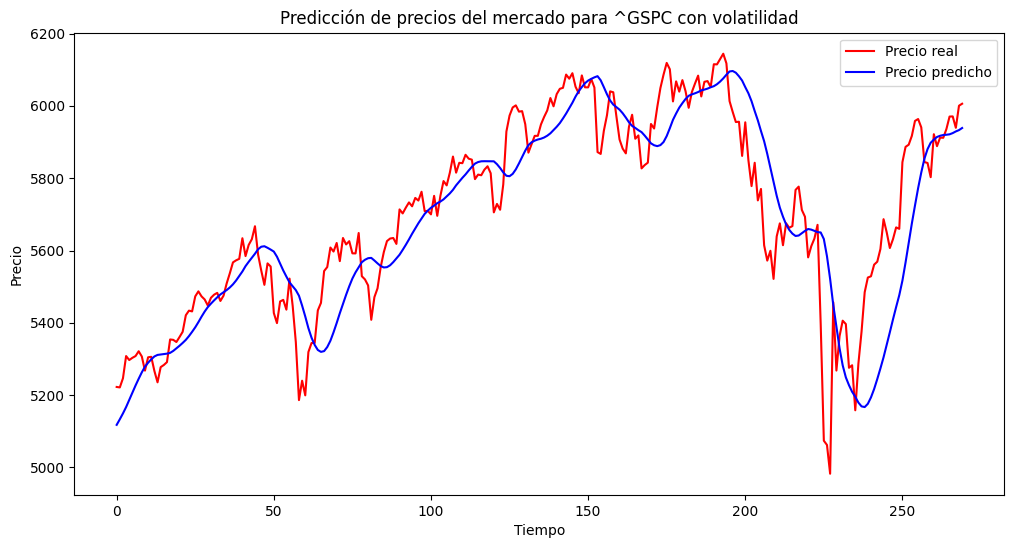

In [17]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Descargar datos de Yahoo Finance
ticker = '^GSPC'  # Puedes cambiar este valor por cualquier otro símbolo
data = yf.download(ticker, start='2019-10-01', end='2025-06-10')

# Usaremos la columna de precios de cierre ajustado (Adj Close) como la serie temporal de precios
data = data[['Close']]
data = data.rename(columns={'Close': 'Price'})

# 2. Calcular el retorno logarítmico y la volatilidad
data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
data['Volatility'] = data['Log Return'].rolling(window=21).std() * np.sqrt(252)  # Ventana móvil de 21 días

# Rellenar valores NaN de las primeras filas
data = data.dropna()

# 3. Preprocesamiento de datos (Precios y Volatilidad)
prices = data['Price'].values.reshape(-1, 1)
volatility = data['Volatility'].values.reshape(-1, 1)

# Normalización de precios y volatilidad
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_volatility = MinMaxScaler(feature_range=(0, 1))

scaled_prices = scaler_price.fit_transform(prices)
scaled_volatility = scaler_volatility.fit_transform(volatility)

# Combinar precios y volatilidad en un array multidimensional (dos características)
scaled_data = np.hstack((scaled_prices, scaled_volatility))


# 4. Crear secuencias de entrada y salida
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 0])  # La salida es el precio futuro
    return np.array(X), np.array(y)

sequence_length = 60  # Usar los últimos 60 días para predecir
X, y = create_sequences(scaled_data, sequence_length)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Ajustar las dimensiones de entrada (X) para la red LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))  # 2 características (precio y volatilidad)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

# 5. Definir la red LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 2)))
model.add(LSTM(units=50))
model.add(Dense(1))  # Capa de salida para predecir el precio

model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32)

# 7. Hacer predicciones
predicted_prices = model.predict(X_test)

# Inversión de la normalización
predicted_prices = scaler_price.inverse_transform(predicted_prices)

# Comparar con los precios reales
real_prices = scaler_price.inverse_transform(y_test.reshape(-1, 1))

# 8. Visualización
plt.subplots(figsize=(12, 6))
plt.plot(real_prices, color='red', label='Precio real')
plt.plot(predicted_prices, color='blue', label='Precio predicho')
plt.title('Predicción de precios del mercado para ' + ticker + ' con volatilidad')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0886
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0020
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.5362e-04
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.4684e-04
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 8.7795e-04
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 8.5130e-04
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.3370e-04
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.6106e-04
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.1836e-04
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.8432e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


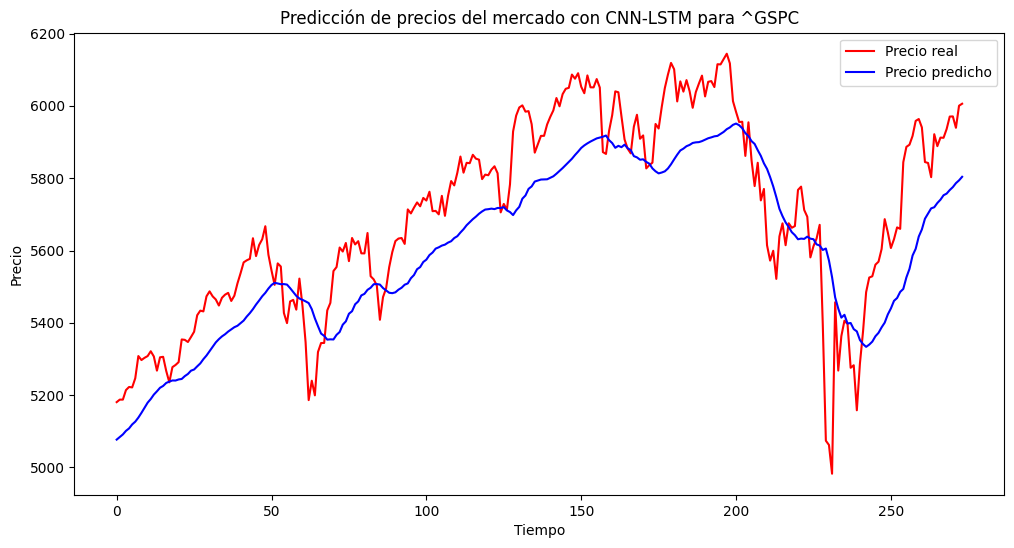

In [18]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Descargar datos de Yahoo Finance
ticker = '^GSPC'  # Puedes cambiar este valor por cualquier otro símbolo
data = yf.download(ticker, start='2019-10-01', end='2025-06-10')

# Usamos la columna de precios de cierre ajustado (Adj Close)
data = data[['Close']]
data = data.rename(columns={'Close': 'Price'})

# 2. Preprocesar datos
prices = data['Price'].values.reshape(-1, 1)

# Normalizar precios
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# 3. Crear secuencias de entrada y salida
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60  # Usar los últimos 60 días para predecir
X, y = create_sequences(scaled_prices, sequence_length)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Ajustar las dimensiones de entrada para la CNN y LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 4. Definir el modelo híbrido CNN + LSTM
model = Sequential()

# Agregar la capa convolucional
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))  # Reducción de dimensionalidad

# En lugar de Flatten(), mantenemos la estructura tridimensional para la LSTM
model.add(LSTM(units=50, return_sequences=False))

# Capa de salida
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32)

# 6. Hacer predicciones
predicted_prices = model.predict(X_test)

# Inversión de la normalización
predicted_prices = scaler.inverse_transform(predicted_prices)

# Comparar con los precios reales
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Visualización
plt.subplots(figsize=(12, 6))
plt.plot(real_prices, color='red', label='Precio real')
plt.plot(predicted_prices, color='blue', label='Precio predicho')
plt.title('Predicción de precios del mercado con CNN-LSTM para ' + ticker)
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()